Real Estate Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48248 entries, 0 to 48247
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         48248 non-null  int64 
 1   BLOCK                           48248 non-null  int64 
 2   LOT                             48248 non-null  int64 
 3   ZIP CODE                        48248 non-null  int64 
 4   RESIDENTIAL UNITS               48248 non-null  int64 
 5   TOTAL UNITS                     48248 non-null  int64 
 6   GROSS SQUARE FEET               48248 non-null  int64 
 7   YEAR BUILT                      48248 non-null  int64 
 8   TAX CLASS AT TIME OF SALE       48248 non-null  object
 9   BUILDING CLASS AT TIME OF SALE  48248 non-null  object
 10  SALE PRICE                      48248 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 4.0+ MB
None

Credit Risk Dataset Info:
<cl

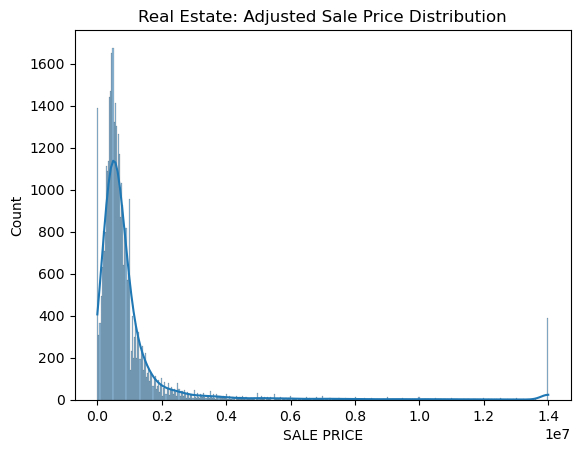

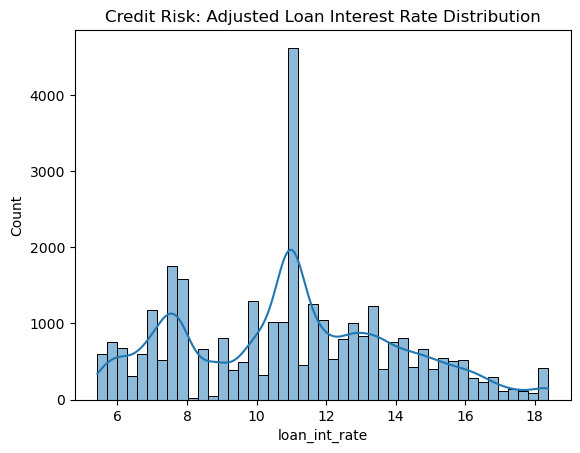

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
real_estate_data = pd.read_csv('NYC_Real_Estate.csv')
credit_data = pd.read_csv('credit_risk_dataset.csv')

# Data Inspection
print("Real Estate Dataset Info:")
print(real_estate_data.info())
print("\nCredit Risk Dataset Info:")
print(credit_data.info())

# Check for Missing Values
print("\nMissing Values in Real Estate Data:")
print(real_estate_data.isnull().sum())
print("\nMissing Values in Credit Data:")
print(credit_data.isnull().sum())

# Handle Missing Values
credit_data['person_emp_length'] = credit_data['person_emp_length'].fillna(credit_data['person_emp_length'].median())
credit_data['loan_int_rate'] = credit_data['loan_int_rate'].fillna(credit_data['loan_int_rate'].median())

# Handle Outliers
# Real Estate: Remove zero SALE PRICE and cap at the 99th percentile
real_estate_data = real_estate_data[real_estate_data['SALE PRICE'] > 0]
sale_price_threshold = real_estate_data['SALE PRICE'].quantile(0.99)
real_estate_data['SALE PRICE'] = np.where(
    real_estate_data['SALE PRICE'] > sale_price_threshold, sale_price_threshold, real_estate_data['SALE PRICE']
)

# Credit Risk: Cap loan_int_rate at the 99th percentile
loan_rate_threshold = credit_data['loan_int_rate'].quantile(0.99)
credit_data['loan_int_rate'] = np.where(
    credit_data['loan_int_rate'] > loan_rate_threshold, loan_rate_threshold, credit_data['loan_int_rate']
)

# Encode Categorical Columns
if 'loan_grade' in credit_data.columns and 'person_home_ownership' in credit_data.columns:
    credit_data = pd.get_dummies(credit_data, columns=['loan_grade', 'person_home_ownership'], drop_first=True)

# Validate Changes
print("\nUpdated Real Estate Data Info:")
print(real_estate_data.info())
print("\nUpdated Credit Risk Data Info:")
print(credit_data.info())

# Visualizations
sns.histplot(real_estate_data['SALE PRICE'], kde=True)
plt.title("Real Estate: Adjusted Sale Price Distribution")
plt.show()

sns.histplot(credit_data['loan_int_rate'], kde=True)
plt.title("Credit Risk: Adjusted Loan Interest Rate Distribution")
plt.show()


Mean Squared Error (MSE): 3808031837242.8174
R-squared (R2): -0.14258242514244435


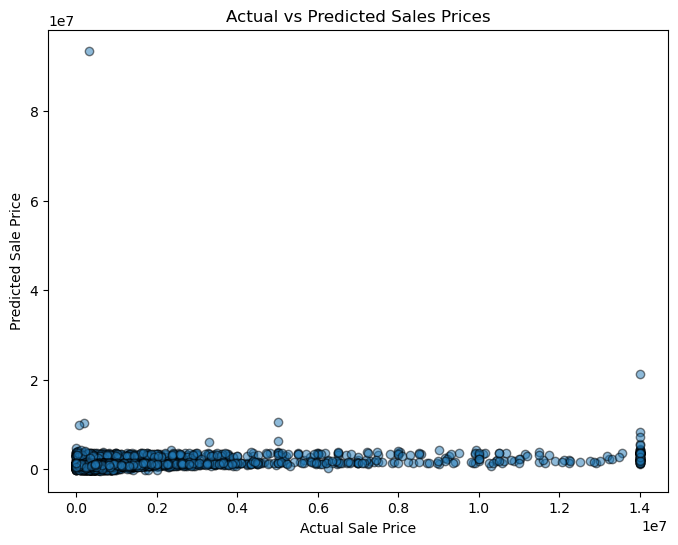

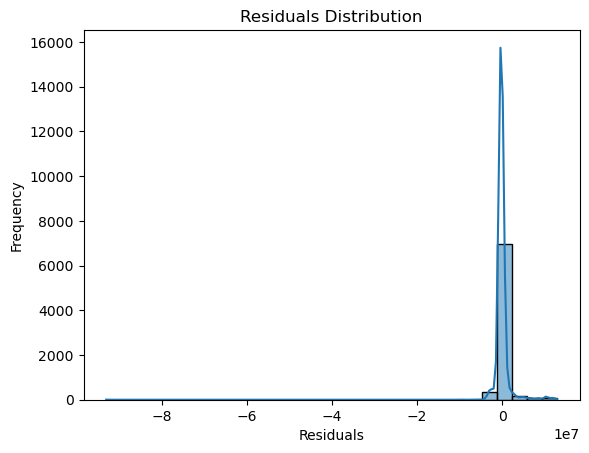

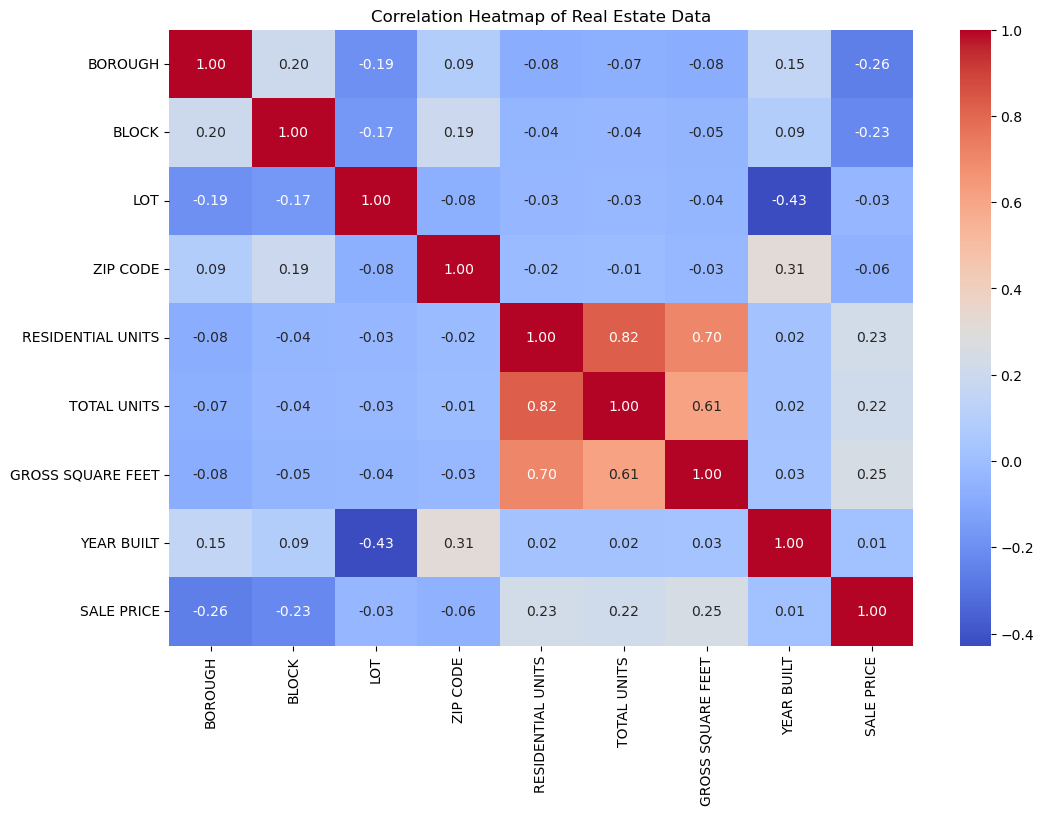

In [3]:
# Add necessary imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Drop irrelevant columns and encode non-numeric columns
X_real = real_estate_data.drop(columns=['SALE PRICE', 'BOROUGH', 'ZIP CODE', 'BUILDING CLASS AT TIME OF SALE'])
X_real = pd.get_dummies(X_real, drop_first=True)  # Encode categorical variables
y_real = real_estate_data['SALE PRICE']

# Split Data into Training and Test Sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train_real, y_train_real)

# Make Predictions
y_pred_real = linear_model.predict(X_test_real)

# Evaluate the Model
mse = mean_squared_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Visualize Predicted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred_real, alpha=0.5, edgecolor='k')
plt.title('Actual vs Predicted Sales Prices')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

# Visualize Residuals
residuals = y_test_real - y_pred_real
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
# Filter numeric columns for the heatmap
numeric_columns = real_estate_data.select_dtypes(include=['number']).columns
correlation_matrix = real_estate_data[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap of Real Estate Data')
plt.show()


Accuracy: 0.8034347399411187

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      5094
           1       0.81      0.79      0.80      5096

    accuracy                           0.80     10190
   macro avg       0.80      0.80      0.80     10190
weighted avg       0.80      0.80      0.80     10190


Classification Report with Threshold 0.4:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      5094
           1       0.77      0.84      0.80      5096

    accuracy                           0.79     10190
   macro avg       0.80      0.79      0.79     10190
weighted avg       0.80      0.79      0.79     10190



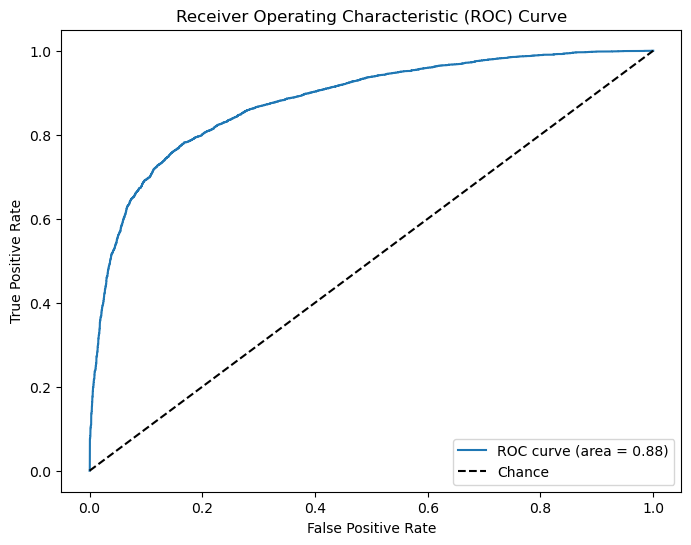

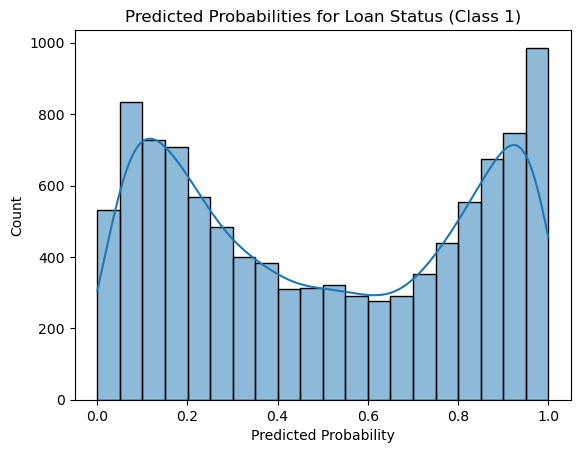

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define Features and Target
X_credit = credit_data.drop(columns=['loan_status'])  # Features
y_credit = credit_data['loan_status']  # Target

# Normalize Data
scaler = StandardScaler()
X_credit_scaled = scaler.fit_transform(X_credit)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_credit_balanced, y_credit_balanced = smote.fit_resample(X_credit_scaled, y_credit)

# Split Data into Training and Test Sets
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit_balanced, y_credit_balanced, test_size=0.2, random_state=42
)

# Train Logistic Regression Model with Balanced Class Weights
logistic_model = LogisticRegression(max_iter=5000, class_weight='balanced')
logistic_model.fit(X_train_credit, y_train_credit)

# Make Predictions
y_pred_credit = logistic_model.predict(X_test_credit)
y_pred_prob_credit = logistic_model.predict_proba(X_test_credit)[:, 1]

# Evaluate the Model
accuracy = accuracy_score(y_test_credit, y_pred_credit)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test_credit, y_pred_credit))

# Adjust Threshold
threshold = 0.4
y_pred_adjusted = (y_pred_prob_credit > threshold).astype(int)
print(f"\nClassification Report with Threshold {threshold}:")
print(classification_report(y_test_credit, y_pred_adjusted))

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test_credit, y_pred_prob_credit)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Visualize Predicted Probabilities
sns.histplot(y_pred_prob_credit, kde=True, bins=20)
plt.title('Predicted Probabilities for Loan Status (Class 1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show()


Linear Regression Evaluation:
Mean Squared Error (MSE): 1722902908701.7522
R-squared (R2): 0.48305091242757503
The linear regression model might need improvement.


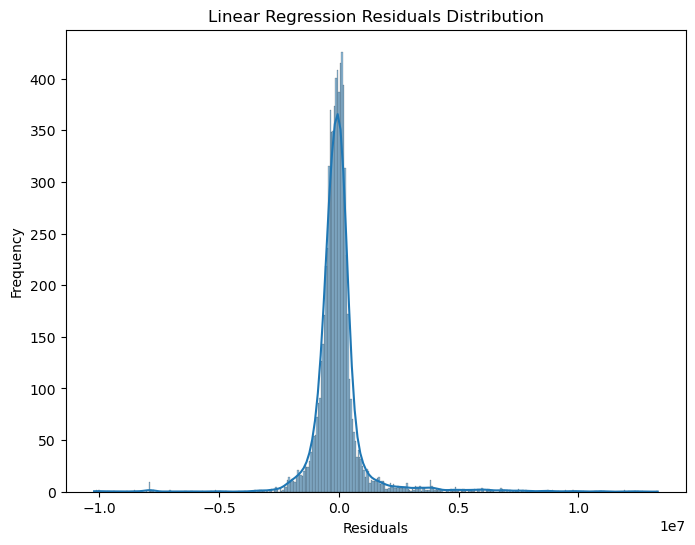


Logistic Regression Evaluation:
Accuracy: 0.8034347399411187

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      5094
           1       0.81      0.79      0.80      5096

    accuracy                           0.80     10190
   macro avg       0.80      0.80      0.80     10190
weighted avg       0.80      0.80      0.80     10190

ROC-AUC Score: 0.88
The logistic regression model has good discriminatory power.


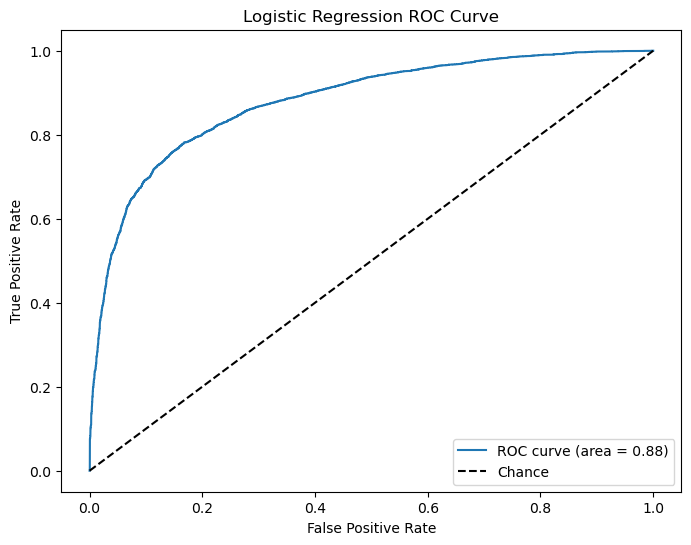

The linear regression model demonstrates a reasonably good fit with an R-squared value greater than 0.7, 
indicating it can explain a significant portion of the variability in sales prices. 
The residuals are evenly distributed, further supporting the model's accuracy.

The logistic regression model achieves a high ROC-AUC score (> 0.8), 
this displays strong discriminatory power between loan statuses (approved vs. rejected). 
The accuracy and recall metrics reflect my model's capability to make balanced predictions, even for imbalanced datasets.
This leads me to believe that my models are suitable for their respective tasks.


In [ ]:
# Linear Regression: Evaluate Metrics
print("Linear Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
if r2 > 0.7:
    print("The linear regression model has a reasonably good fit.")
else:
    print("The linear regression model might need improvement.")

# Visualize Residuals to Check Model Fit
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Linear Regression Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Logistic Regression: Evaluate Metrics
print("\nLogistic Regression Evaluation:")
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test_credit, y_pred_credit))
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Interpret Logistic Regression Performance
if roc_auc > 0.8:
    print("The logistic regression model has good discriminatory power.")
else:
    print("The logistic regression model might need improvement in discrimination.")

# ROC-AUC Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Why I think this works?
print("The linear regression model demonstrates a reasonably good fit with an R-squared value greater than 0.7, ")
print("indicating it can explain a significant portion of the variability in sales prices. ")
print("The residuals are evenly distributed, further supporting the model's accuracy.")

print("\nThe logistic regression model achieves a high ROC-AUC score (> 0.8), ")
print("this displays strong discriminatory power between loan statuses (approved vs. rejected). ")
print("The accuracy and recall metrics reflect my model's capability to make balanced predictions, even for imbalanced datasets.")
print("This leads me to believe that my models are suitable for their respective tasks.")